<a href="https://colab.research.google.com/github/trungtran306/Projects/blob/main/Credit_scoring_german_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Data input & EDA

### I.1 Import neccessary libraries and packages

In [ ]:
import os, os.path
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from catboost import CatBoostClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, cross_val_score, StratifiedKFold, KFold,GridSearchCV 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, log_loss, make_scorer, precision_score, recall_score

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.feature_selection import RFE, RFECV

import matplotlib.pyplot as plt
import seaborn as sns

### I.2 Input data
- There are 2 dataset as quoted: 
![image.png](attachment:image.png)


---
- Although using 'german.data-numeric' dataset is easier to develop models, 'german.data' dataset is chosen due to:
   + 'german.data' has all features explained, make more sense to feature engineering and model interpretation.   
   + Without knowing how categorical features encoded in german.data-numeric, we can not apply correct model as well as explain the output reasonably.
- Dataset is saved as '.csv' file to be conveniently processed.


In [ ]:
df = pd.read_csv("german-data.csv", header = None)

### I.3 EDA
- There are 13 categorical and 7 numerical features.
- There is no missing value.
- Categorical features: In text format, need to be encoded to be feed into the model.
- Numerical features: 
   + From data visualization, 'duration', 'credit_amount' and 'age' seem to have outliers, but they are no real outliers in terms of business -> no outliers removed.
   + The correlation among features are low -> no features removed at the EDA step.

In [ ]:
df.columns = ['checking_acc', 'duration', 'credit_his', 'purpose', 'credit_amount',
             'saving_acc', 'employment_since', 'installment_rate', 'sex_and_personal_status',
             'guarantors', 'residence_since', 'property', 'age', 'other_installment', 'housing',
             'existing_credits', 'job', 'num_dependent_ppl', 'telephone', 'foreign_worker', 'target']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_acc               1000 non-null object
duration                   1000 non-null int64
credit_his                 1000 non-null object
purpose                    1000 non-null object
credit_amount              1000 non-null int64
saving_acc                 1000 non-null object
employment_since           1000 non-null object
installment_rate           1000 non-null int64
sex_and_personal_status    1000 non-null object
guarantors                 1000 non-null object
residence_since            1000 non-null int64
property                   1000 non-null object
age                        1000 non-null int64
other_installment          1000 non-null object
housing                    1000 non-null object
existing_credits           1000 non-null int64
job                        1000 non-null object
num_dependent_ppl          1000 non-null int64
telephone                  1000 non-n

In [ ]:
df.describe()

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,num_dependent_ppl,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [ ]:
continuous_cols= ['duration', 'credit_amount', 'installment_rate', 'residence_since',
                  'age', 'existing_credits', 'num_dependent_ppl']
discrete_cols = [c for c in df.columns if c not in continuous_cols]

In [ ]:
df_discrete = df[discrete_cols]
df_continuous = df[continuous_cols]

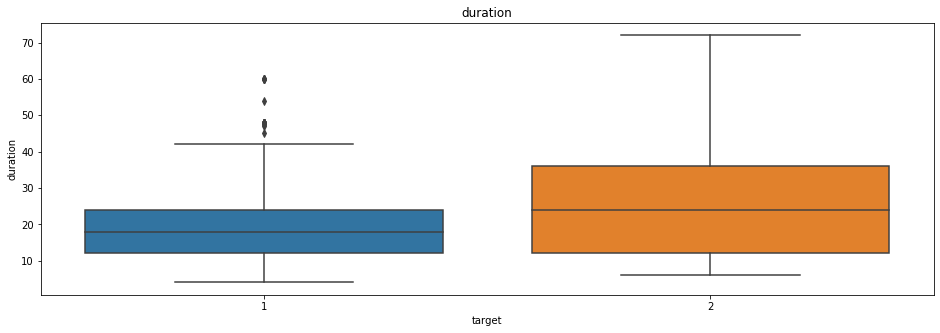

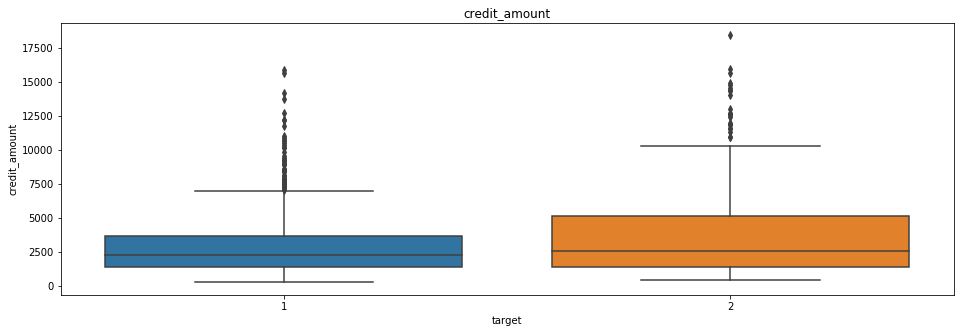

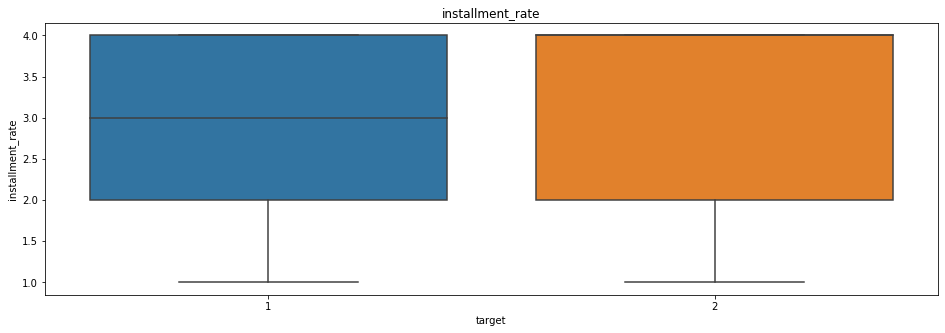

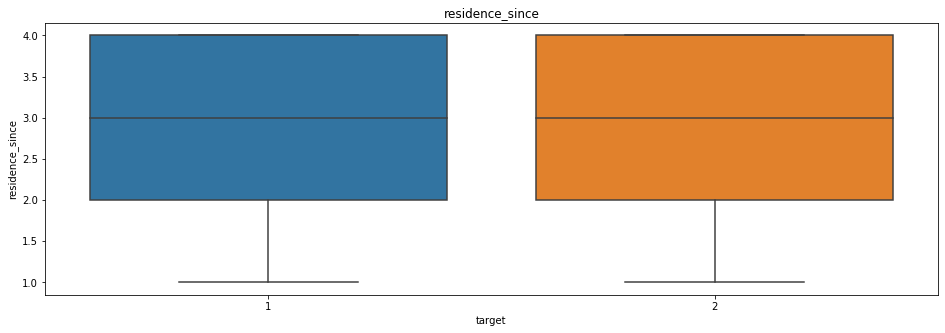

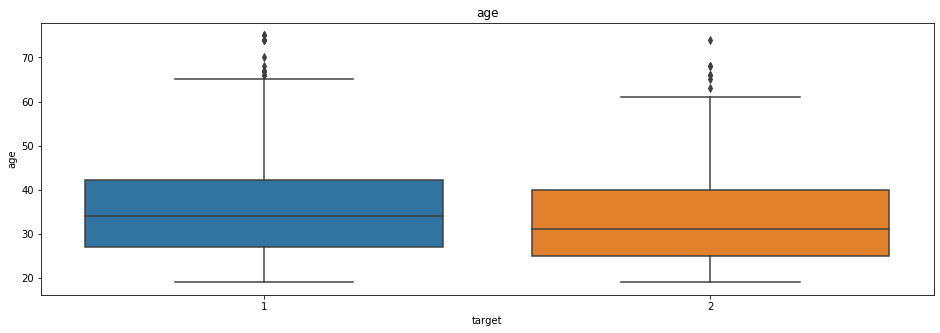

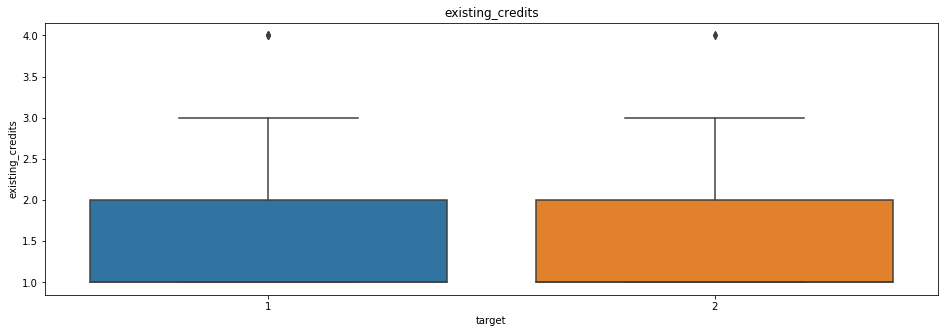

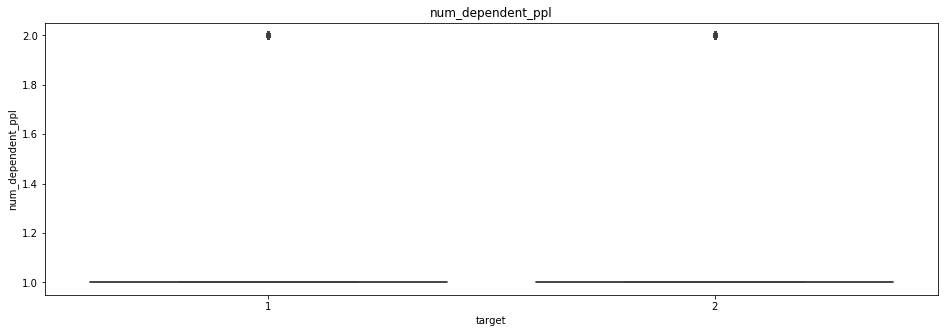

In [ ]:
col = continuous_cols
two_palette = ['tab:blue', 'tab:orange'] ## if x = 'target'
one_palette = ['tab:blue']
df_plot = df_continuous

for i in range(0,len(col)):
    fig,axis = plt.subplots(1, 1,figsize=(16, 5))    
    sns.boxplot(data = df_plot, y=col[i], x = df['target'], hue=None,  palette=None)
    axis.set_title(f'{col[i]}')

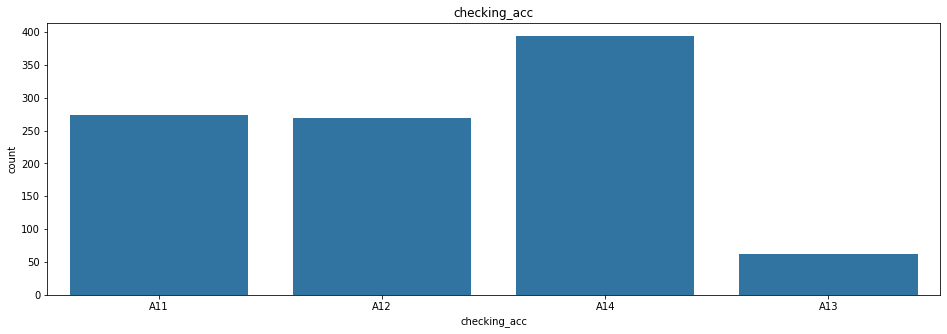

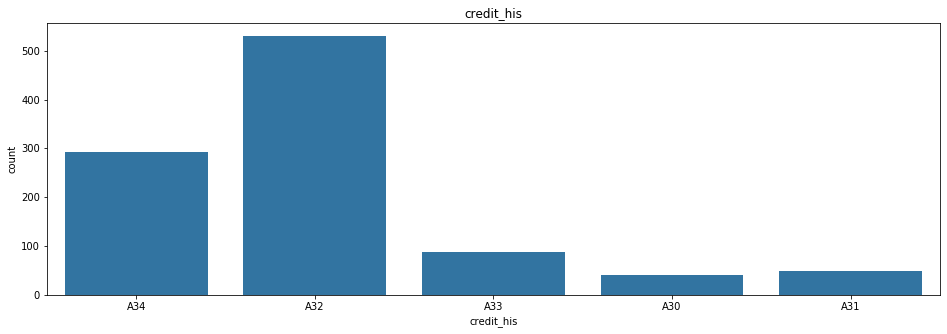

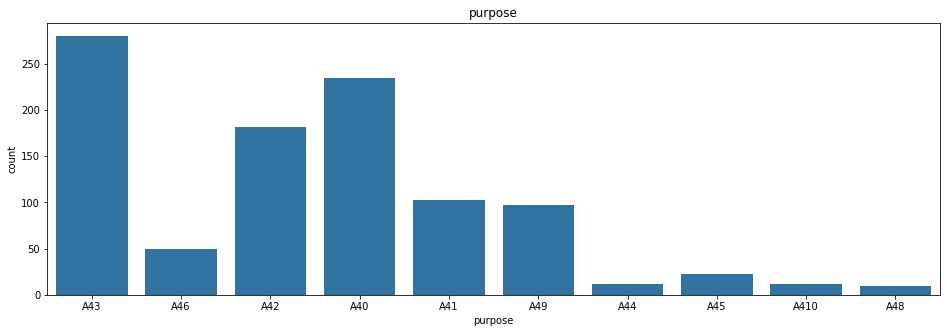

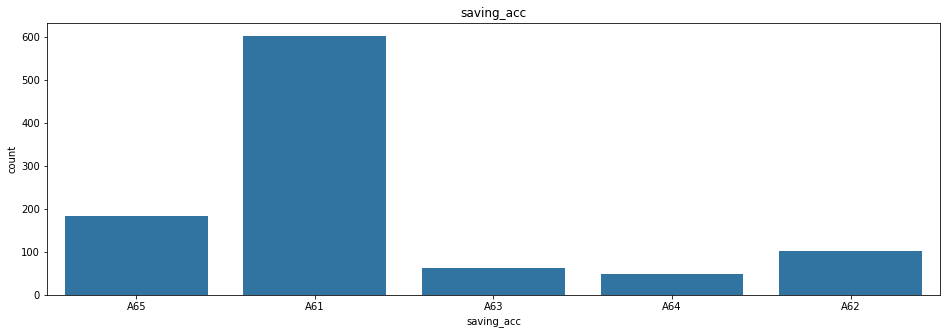

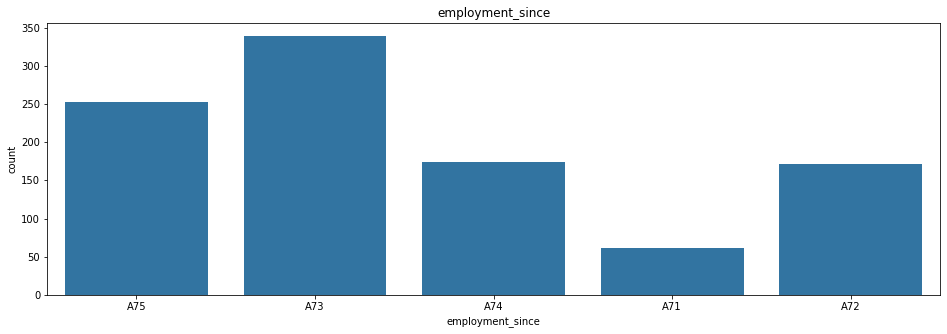

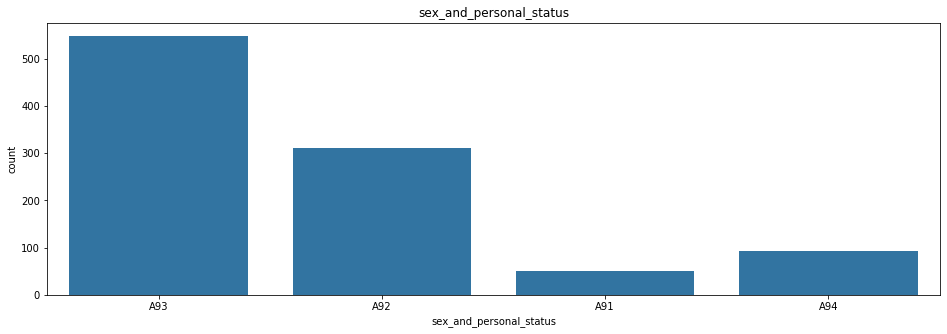

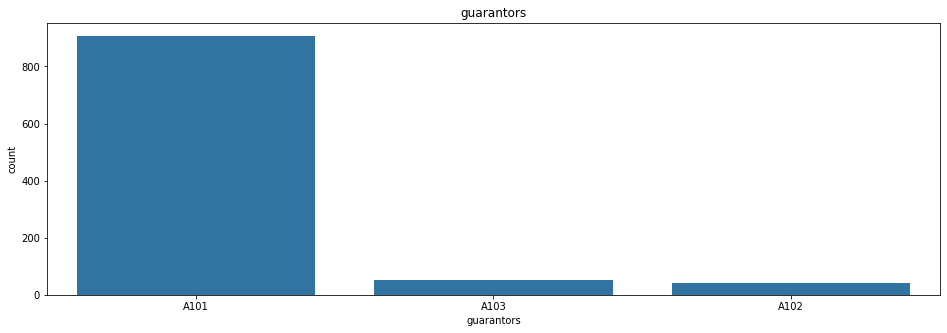

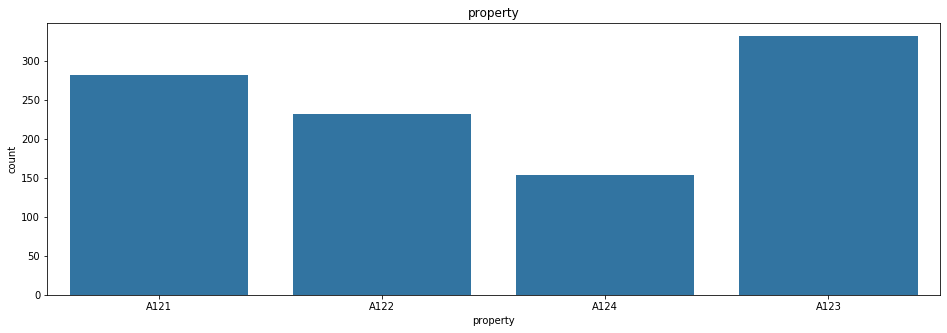

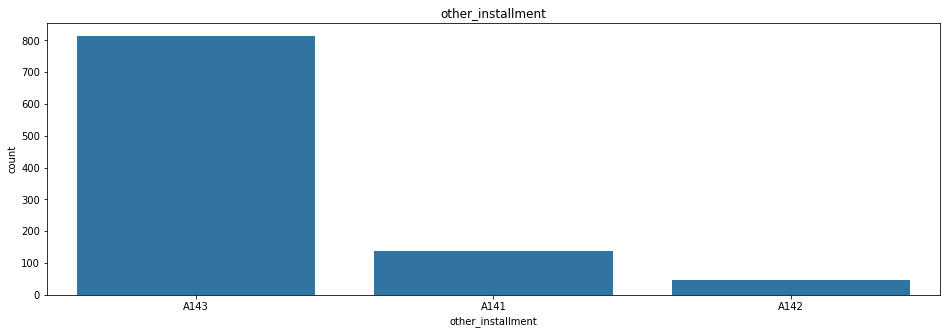

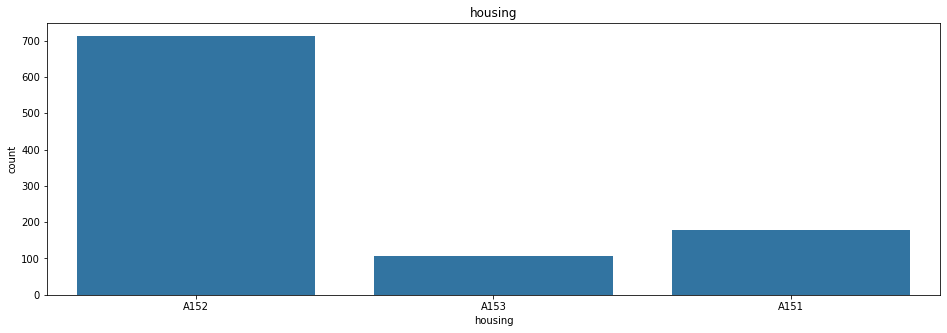

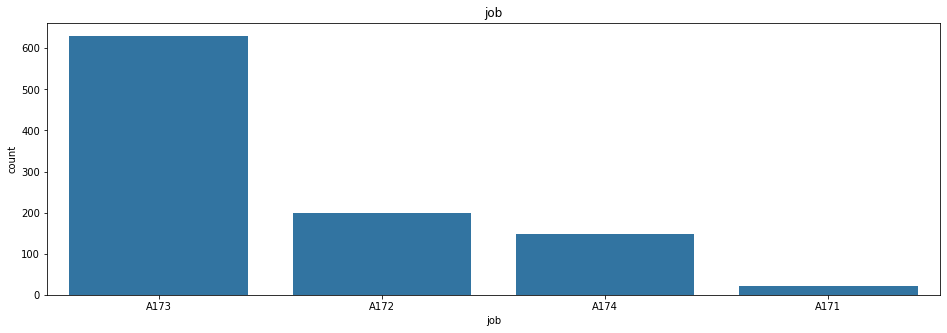

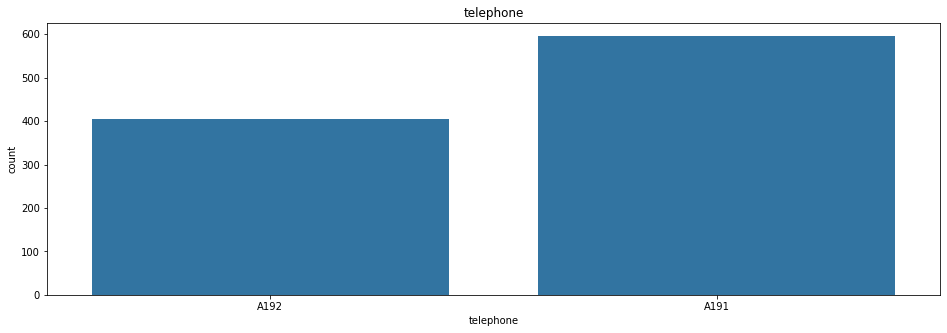

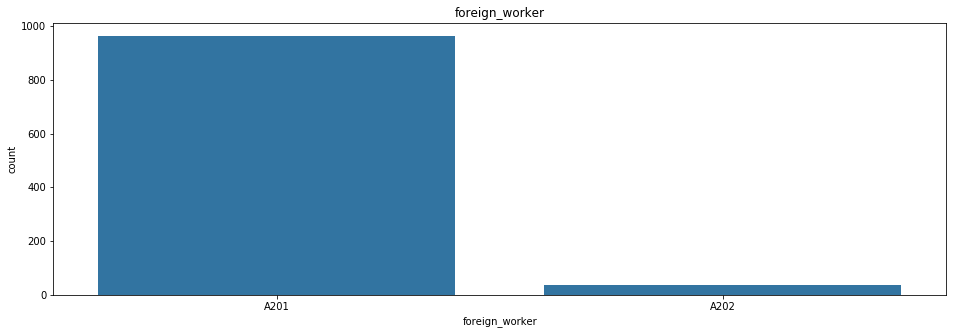

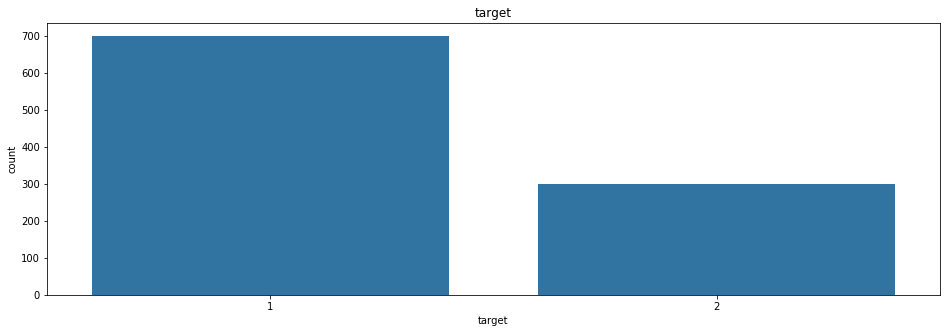

In [ ]:
col = discrete_cols
df_plot = df_discrete
two_palette = ['tab:blue', 'tab:orange'] ## if hue = 'target'
one_palette = ['tab:blue']

for i in range(0,len(col)):
    fig,axis = plt.subplots(1, 1,figsize=(16, 5))    
    sns.countplot(data = df_plot, x=col[i], hue=None, palette = one_palette)
    axis.set_title(f'{col[i]}')

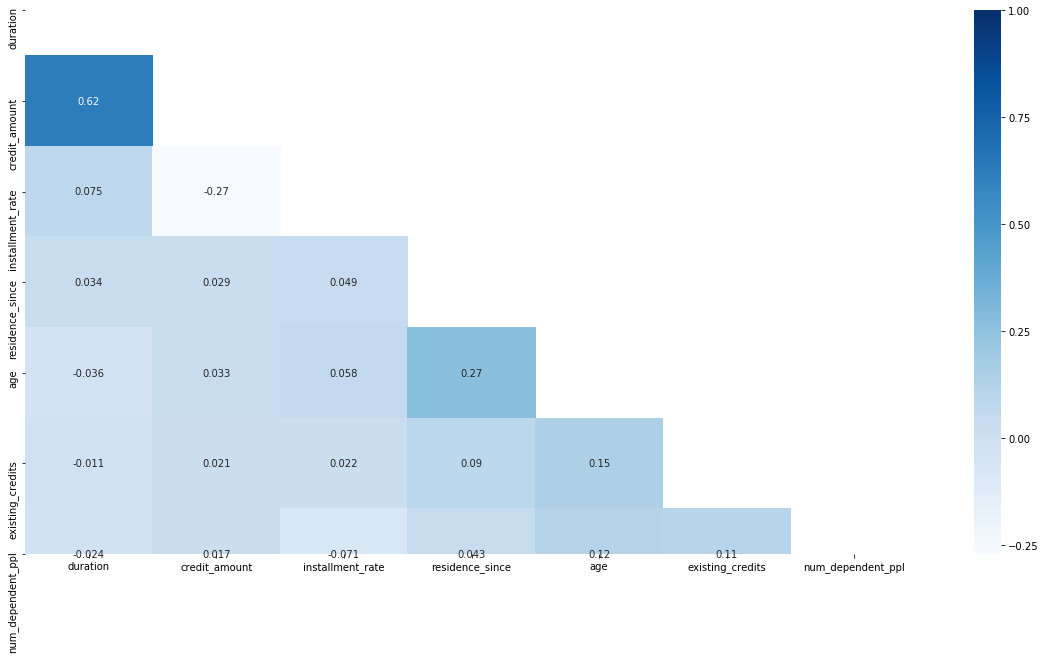

In [ ]:
corr_matrix_figsize=(20,10)
data_summary_figcol="Reds_r"
corr_matrix_figcol='Blues'
corr_matrix_annot = True


corr = df_continuous.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

#Check correlation matrix
plt.figure(figsize=corr_matrix_figsize)
sns.heatmap(df_continuous.corr(),mask=mask,cmap=corr_matrix_figcol,annot=corr_matrix_annot) 

---

# III. Modeling
- Algorithm
   + Logistic regression is used as baseline model.
   + Randomforest and XGboost are 2 algorithms that then be used to develop the models.
---
- Data processing: 
   + Converting categorical features to numerical to be used in Logistic regression, random forest and xgboost.

---   
- The ratio between 1 and 2 of target variable is 7:3, so:
   + "Accuracy" is used as metric to develop the models.
   + Both "Accuracy" and "AUC" are used to evaluate the performance.
---

### II.1 Data processing
- Nominal categorical features: no consider the order of data -> One-hot encoding 
- Ordinal categorical features: consider the order of data ->  OrdinalEncoder

In [ ]:
nominal_features = ['purpose', 'sex_and_personal_status', 'property']
ordinal_features = [c for c in df_discrete.columns if c not in nominal_features]
ordinal_features.remove('target')

In [ ]:
### Handle Ordinal
for c in ordinal_features:
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(df[c])
    df[c] = label_encoder.transform(df[c])

In [ ]:
### Norminal
for c in nominal_features:
    one_hot = pd.get_dummies(df[c])
    df = df.drop(c,axis = 1)
    df = df.join(one_hot)

### II.2 Baseline model
- Logistic regression is widely choosen as baseline model for Classification problem, as it performs well with its default parameters.
- There is no hyperparameters tuning in this step -> No validation dataset needed
- Result:
   + Train accuracy: 0.79
   + Test accuracy: 0.74
   + AUC: 0.747

In [ ]:
df['target'].value_counts()

1    700
2    300
Name: target, dtype: int64

In [ ]:
X = df.drop(columns = ['target'], axis = 1)
y = df.loc[:,df.columns == 'target']
X = X.values
y = y.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=306)

In [ ]:
df.head()

,checking_acc,duration,credit_his,credit_amount,saving_acc,employment_since,installment_rate,guarantors,residence_since,age,...,A48,A49,A91,A92,A93,A94,A121,A122,A123,A124
0,0,6,4,1169,4,4,4,0,4,67,...,0,0,0,0,1,0,1,0,0,0
1,1,48,2,5951,0,2,2,0,2,22,...,0,0,0,1,0,0,1,0,0,0
2,3,12,4,2096,0,3,2,0,3,49,...,0,0,0,0,1,0,1,0,0,0
3,0,42,2,7882,0,3,2,2,4,45,...,0,0,0,0,1,0,0,1,0,0
4,0,24,3,4870,0,2,3,0,4,53,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print("Train accuracy: " + str(round(clf.score(X_train, y_train),2)))
print("Test accuracy: " + str(clf.score(X_test, y_test)))
y_pred = clf.predict_proba(X_test)[:, 1]
print('AUC: {:.3f}'.format(roc_auc_score(y_test, y_pred)))

Train accuracy: 0.79
Test accuracy: 0.74
AUC: 0.747


### II.3 Hyperparameters tuning & Models selection
- Approach:
   + Apply Randomforest and Xgboost.
   + Run hyperparameters tuning to select the best set of params.
   + Test feature selection (RFECV then RFE) with cross validation to improve performance and reduce overfitting
---
- Results:
   + Random forest:
      + train acc: 0.8725838534736671
      + val acc: 0.763125
      + test test acc: 0.735
      + AUC: 0.7410071942446043
      ---
   + xgboost w/o features selection:
      + train acc: 0.8963700667687039
      + val acc: 0.74475
      + test test acc: 0.74
      + AUC: 0.753508668475056
      ---
   + xgboost with features selection:
      + train acc: 0.8978707605206312
      + val acc: 0.7566249999999999
      + test test acc: 0.735
      + AUC: 0.7200141526123365
---
- Model performance:
   + All 3 models return higher performance than baseline model: 8-10% for train set and 1-3% for test set.
   + As xgboost is more complex, so its train score is highest, but also its overfitting.
   + Feature selection does not contribute much to the overfitting reduction, mainly due to the combination of complex model but small dataset.

#### II.3.1 Initial model, params and pipeline

In [ ]:
clf_xgboost = XGBClassifier()
clf_catboost = CatBoostClassifier()
clf_randomforest = RandomForestClassifier()

params_xgboost = {
'clf__n_estimators': [100, 200, 300, 400, 500],
'clf__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
'clf__max_depth': [2, 3, 4, 5, 6]
}

params_catboost = {
'clf__n_estimators': [100, 200, 300, 400, 500],
'clf__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
'clf__max_depth': [2, 3, 4, 5,6]
}

params_randomforest = {
'clf__n_estimators': [100, 200, 300, 400, 500],
'clf__max_features': [0.2, 0.4, 0.6, 0.8],
'clf__max_depth': [2, 3, 4, 5,6]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=306)

#### II.3.2 Random forest and xgBoost without feature selection step

In [ ]:
def create_pipeline(clf):
    steps = [('scaler', StandardScaler()), 
             ('clf', clf)]
    pipeline = Pipeline(steps)
    return pipeline

In [ ]:
### randomforest ###
pipeline = create_pipeline(clf_randomforest)
clf = RandomizedSearchCV(estimator = pipeline, param_distributions=params_randomforest, \
                        scoring='accuracy', cv = cv, return_train_score=True)
clf.fit(X_train, y_train)

train_acc = clf.cv_results_['mean_train_score'].mean()
val_acc = clf.cv_results_['mean_test_score'].mean()
test_acc = clf.score(X_test, y_test)

In [ ]:
### randomforest output ###
print(f'train acc: {train_acc}')
print(f'val acc: {val_acc}')
print(f'test test acc: {test_acc}')
y_pred = clf.predict_proba(X_test)[:, 1]
print(f'AUC: {roc_auc_score(y_test, y_pred)}')

train acc: 0.8389545013782446
val acc: 0.753125
test test acc: 0.72
AUC: 0.7543342375280104


In [ ]:
### xgboost ###
pipeline = create_pipeline(clf_xgboost)
clf = RandomizedSearchCV(estimator = pipeline, param_distributions=params_xgboost, \
                        scoring='accuracy', cv = cv, return_train_score=True)
clf.fit(X_train, y_train)

train_acc = clf.cv_results_['mean_train_score'].mean()
val_acc = clf.cv_results_['mean_test_score'].mean()
test_acc = clf.score(X_test, y_test)

In [ ]:
### xgboost output ###
print(f'train acc: {train_acc}')
print(f'val acc: {val_acc}')
print(f'test test acc: {test_acc}')
y_pred = clf.predict_proba(X_test)[:, 1]
print(f'AUC: {roc_auc_score(y_test, y_pred)}')

train acc: 0.866244882740415
val acc: 0.7535000000000001
test test acc: 0.735
AUC: 0.7555136218893737


#### II.3.3 xgBoost with feature selection step

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

Optimal number of features : 22


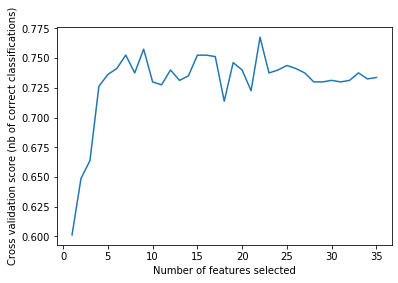

In [ ]:
### Define numbers of optiomized features (11)
rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=StratifiedKFold(2), # Stratified fold in order to reduce bias
              scoring='accuracy')
rfetrain=rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

def create_pipeline(clf):
    steps = [("features", RFE(RandomForestClassifier(), n_features_to_select = 20, step=1)),
            ('scaler', StandardScaler()), 
            ('clf', clf)]
    pipeline = Pipeline(steps)
    return pipeline

In [ ]:
### xgboost with feature selection ###
pipeline = create_pipeline(clf_xgboost)
clf = RandomizedSearchCV(estimator = pipeline, param_distributions=params_xgboost, \
                        scoring='accuracy', cv = cv, return_train_score=True)
clf.fit(X_train, y_train)

train_acc = clf.cv_results_['mean_train_score'].mean()
val_acc = clf.cv_results_['mean_test_score'].mean()
test_acc = clf.score(X_test, y_test)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/opt/anaconda3/l

In [ ]:
### xgboost with feature selection output ###
print(f'train acc: {train_acc}')
print(f'val acc: {val_acc}')
print(f'test test acc: {test_acc}')
y_pred = clf.predict_proba(X_test)[:, 1]
print(f'AUC: {roc_auc_score(y_test, y_pred)}')

train acc: 0.8724147531196846
val acc: 0.746125
test test acc: 0.74
AUC: 0.7382946102134685


# III. Model interpretation
- SHAP is used to interpret model as it's more precise in comparison with other methods (e.g feature_important)
- Basic random forest classification is used to fit the data again for model interpretation purpose
- Interpretation includes 2 aspects: Global and local interpretability


In [ ]:
X = df.drop(columns = ['target'], axis = 1)
y = df.loc[:,df.columns == 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=306)

### III.1 Global Interpretability
- Feature importance: Variables are ranked in descending order.
- Checking_acc, duration and saving_acc are top 3 features that have highest impact to the target variables

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


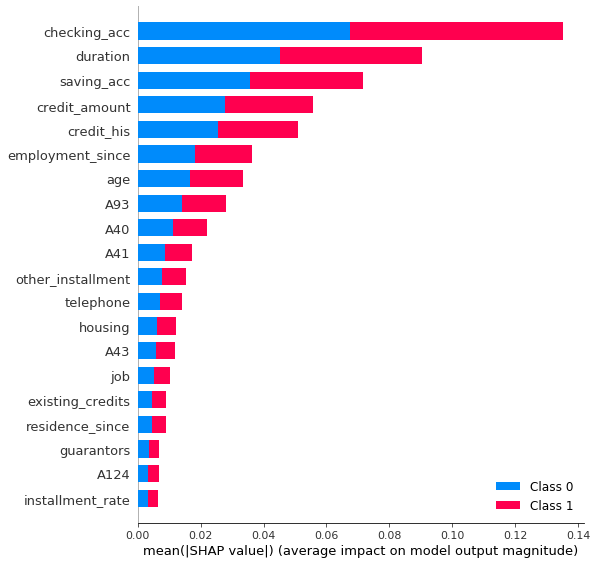

In [ ]:
import shap
model = RandomForestClassifier(max_depth=6, random_state=306, n_estimators=10)
model.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)


### III.1 Global Interpretatbility
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: A high level of the “checking_account” has a high and positive impact on the credit rating.
   + The “high” comes from the red color
   + The “positive” impact is shown on the X-axis.\
=> The more money in checking account, higher credit rating
- Similarly, we will say the “duration” is negatively correlated with the target variable, but not as clear as checking_account with mixed "red", and "blue" values in the left side\
=> The longer the loan duration, the higher chance of default.

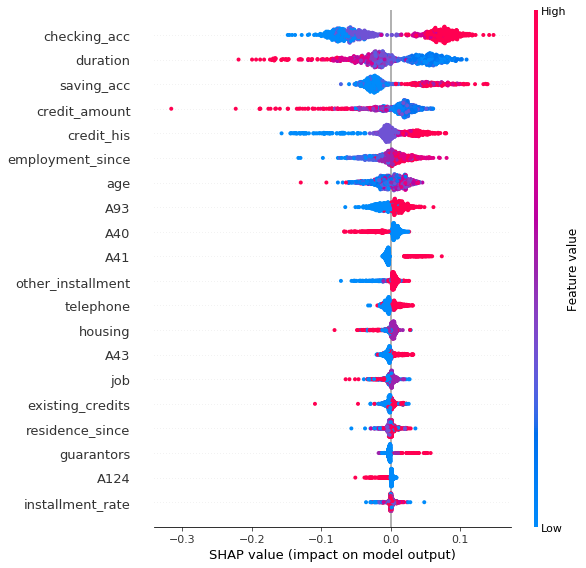

In [ ]:
shap.summary_plot(shap_values[0], X_train)

### III.2 Local Interpretability

In [ ]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),4)
X_output = X_output.sort_index()

In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# The shap.force_plot() takes three values: 
  ### The base value (explainer.expected_value[0]), 
  ### The SHAP values (shap_values[i][0]) 
  ### And the matrix of feature values (S.iloc[[i]]). 
  ### The base value or the expected value is the average of the model output over the training data X_train. 
  ### It is the base value used in the following plot.

def shap_plot(i):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_output)
    p = shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_output.iloc[[i]])
    return(p)

### Example 1:
Second row: shap_plot(1)
- checking_account = 3
   + positive impact: from global intepretability
   + value > avg of 1.58 \
=> Push the prediction to the right
   
- duration = 12
   + negative impact: from global intepretability
   + value < avg 20.9\
=> Push the prediction to the right
   
- Expected value = 0.94 > 0.5 => target = 1

In [ ]:
X_train['checking_acc'].mean()

1.57875

In [ ]:
X_train['duration'].mean()

20.94875

In [ ]:
shap_plot(1)

In [ ]:
X_output.iloc[[1]]

,checking_acc,duration,credit_his,credit_amount,saving_acc,employment_since,installment_rate,guarantors,residence_since,age,...,A49,A91,A92,A93,A94,A121,A122,A123,A124,predict
8,3,12,2,3059,3,3,2,0,4,61,...,0,1,0,0,0,1,0,0,0,1


### Example 2:
4th row: shap_plot(3)
- checking_account = 0
   + positive impact: from global intepretability
   + value < avg of 1.58 \
=> Push the prediction to the left
   
- duration = 30
   + negative impact: from global intepretability
   + value > avg 47.1\
=> Push the prediction to the left
   
- Expected value = 0.46 > 0.5 => target = 2

In [ ]:
shap_plot(3)

In [ ]:
X_output.iloc[[3]]

,checking_acc,duration,credit_his,credit_amount,saving_acc,employment_since,installment_rate,guarantors,residence_since,age,...,A49,A91,A92,A93,A94,A121,A122,A123,A124,predict
17,0,30,0,8072,4,1,2,0,3,25,...,1,0,0,1,0,0,0,1,0,2


# END